<a href="https://colab.research.google.com/github/sohamazing/colorize/blob/main/colorize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Tensorflow setup - one-time

# To determine which version you're using:
!pip show tensorflow

# For the current version:
# !pip install --upgrade tensorflow

# For the latest nightly build (if needed):
# !pip install tf-nightly

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import io
from io import BytesIO
import requests

from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow import pad

In [ ]:
import os
print(os.path.expanduser('~'))

# Training and Validation set paths (use the ratio and quality strings above)
train_path = '/content/drive/MyDrive/train64.npz'
valid_path = '/content/drive/MyDrive/valid64.npz'

# Where to store the trained models.
# Assume they are to be stored in your personal gdrive in 'Colab Notebooks' folder. Change this as you wish.
model_out = '/content/drive/MyDrive/Colab Notebooks/model_color.keras'

# Test set paths
test_path = '/content/drive/MyDrive/test64.npz'

print('train_path: ' + train_path)
print('valid_path: ' + valid_path)
print('test_path:  ' + test_path)
print('model_out: ' + model_out)

# If you want to test a pre-trained model stored as model_out, jump to the
# last section on "Test your pre-trained data on test set"

/root
train_path: /content/drive/MyDrive/train64.npz
valid_path: /content/drive/MyDrive/valid64.npz
test_path:  /content/drive/MyDrive/test64.npz
model_out: /content/drive/MyDrive/Colab Notebooks/model_color.keras


In [ ]:
# Load Training and Validation Data
with np.load(valid_path) as f:
  valid_y, valid_uv = (f['y_array'], f['uv_array'])

with np.load(train_path) as f:
  train_y, train_uv = (f['y_array'], f['uv_array'])

print(train_y.shape, train_uv.shape)
print(valid_y.shape, valid_uv.shape)
patchsize = train_y[0].shape[0]
print(patchsize)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

for i in range (10,20):
  print("\nimage", i, "")
  y = train_y[i].astype(np.uint8)
  u = train_uv[i,:,:,0].astype(np.uint8)
  v = train_uv[i,:,:,1].astype(np.uint8)

  u = np.ravel(u).reshape((u.shape[0]//2,u.shape[1]*2))
  v = np.ravel(v).reshape((v.shape[0]//2,v.shape[1]*2))
  uv = np.vstack((u,v))

  yuv = np.vstack((y,uv))

  print("YUV420p", yuv.shape)
  cv2_imshow(yuv)
  bgr = cv2.cvtColor(yuv, cv2.COLOR_YUV420p2BGR)
  print("BGR", bgr.shape)
  cv2_imshow(bgr)

In [ ]:
def display_yuv_rgb(y_array, uv_array):
  y_imgs = []
  bgr_imgs = []
  for i in range(min(20,len(y_array))):
    print("\nimage", i, "")
    y = y_array[i].astype(np.uint8)
    u = uv_array[i,:,:,0].astype(np.uint8)
    v = uv_array[i,:,:,1].astype(np.uint8)

    #print("Y", y.shape)
    #cv2_imshow(y)
    #print("U", u.shape)
    #cv2_imshow(u)
    #print("V", v.shape)
    #cv2_imshow(v)

    u = np.ravel(u).reshape((u.shape[0]//2,u.shape[1]*2))
    v = np.ravel(v).reshape((v.shape[0]//2,v.shape[1]*2))
    uv = np.vstack((u,v))

    yuv = np.vstack((y,uv))

    print("YUV420p", yuv.shape)
    cv2_imshow(yuv)
    bgr = cv2.cvtColor(yuv, cv2.COLOR_YUV420p2BGR)
    print("BGR", bgr.shape)
    cv2_imshow(bgr)

    y_imgs.append(y)
    bgr_imgs.append(bgr)

  # display all images
  plt.figure(figsize=(10,50))
  plt.grid(False)
  plt.axis('off')
  columns = 2
  num_imgs = len(bgr_imgs)

  for i in range (num_imgs):
      plt.subplot(num_imgs, columns, 2 * i + 1)
      plt.imshow(bgr_imgs[i])
      plt.subplot(num_imgs, columns,  2 * (i + 1))
      plt.imshow(y_imgs[i], cmap='gray')

In [ ]:
display_yuv_rgb(valid_y, valid_uv)

In [ ]:
from scipy import ndimage

def ConvertYUVtoRGB(plane_y, plane_u, plane_v):

  height = plane_y.shape[0]
  width  = plane_y.shape[1]

  height2 = plane_u.shape[0]
  width2 = plane_u.shape[1]

  # upsample if YV12
  if height2 * 2 == height and width2 * 2 == width:
    plane_u = ndimage.zoom(plane_u, 2, order=1)
    plane_v = ndimage.zoom(plane_v, 2, order=1)

  # reshape
  plane_y  = plane_y.reshape((plane_y.shape[0], plane_y.shape[1], 1))
  plane_u  = plane_u.reshape((plane_u.shape[0], plane_u.shape[1], 1))
  plane_v  = plane_v.reshape((plane_v.shape[0], plane_v.shape[1], 1))

  # make YUV of shape [height, width, color_plane]
  yuv = np.concatenate((plane_y, plane_u, plane_v), axis=2)

  yuv = yuv.astype(np.float32)
  yuv[:, :, 0] = yuv[:, :, 0].clip(16, 235) - 16
  yuv[:, :, 1:] = yuv[:, :, 1:].clip(16, 240) - 128

  A = np.array([[1.164,  0.000,  1.596],
                [1.164, -0.392, -0.813],
                [1.164,  2.017,  0.000]])

  # our result
  rgb = np.dot(yuv, A.T).clip(0, 255).astype('uint8')

  return rgb


def display2(y_data, uv_data, patchsize):
    """
    Displays 12 random images from each one of the supplied arrays.
    """
    n = 12
    indices = np.random.randint(len(y_data), size=n)
    y_list = y_data[indices, :]
    uv_list = uv_data[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (y_sample, uv_sample) in enumerate(zip(y_list, uv_list)):
        ax = plt.subplot(2, n, i + 1)
        y = y_sample.reshape(patchsize, patchsize)
        plt.imshow(y, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        uv = uv_sample.reshape(patchsize // 2, patchsize // 2, 2)
        u = uv[:, :, 0]
        v = uv[:, :, 1]
        rgb = ConvertYUVtoRGB(y, u, v)
        plt.imshow(rgb, cmap='jet')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


def display3(y_data, uv_data, uv_data2, patchsize):
    """
    Displays 12 random images from each one of the supplied arrays.
    """

    n = 12
    indices = np.random.randint(len(y_data), size=n)
    y_list = y_data[indices, :]
    uv_list = uv_data[indices, :]
    uv_list2 = uv_data2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (y_sample, uv_sample, uv_sample2) in enumerate(zip(y_list, uv_list, uv_list2)):
        ax = plt.subplot(3, n, i + 1)
        y = y_sample.reshape(patchsize, patchsize)
        plt.imshow(y, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        uv = uv_sample.reshape(patchsize // 2, patchsize // 2, 2)
        u = uv[:, :, 0]
        v = uv[:, :, 1]
        rgb = ConvertYUVtoRGB(y, u, v)
        plt.imshow(rgb)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        uv = uv_sample2.reshape(patchsize // 2, patchsize // 2, 2)
        u = uv[:, :, 0]
        v = uv[:, :, 1]
        rgb = ConvertYUVtoRGB(y, u, v)
        plt.imshow(rgb, cmap='jet')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
def preprocess(array, patchsize):
    """
    Normalizes the supplied array to the [0.0, 1.0] range.
    """
    array = array.astype("float32") / 255.0
    return array

def round_postpredict(array):
    """
    Rounds and clamps array from floating point [0.0, 1.0] range for source
    to 8-bit [0, 255] range after prediction by scaling by 255 and clamping.
    """
    array = np.ndarray.round(array * 255.0)
    array = np.clip(array, 0.0, 255.0)
    return array.astype("uint8")

def get_mse(x, y):
    """
    Gets mse of two tensors of size [batchize, height, width]
    """
    mse = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
    return mse(x.astype(int), y.astype(int)).numpy()

In [ ]:
def net_flops(model, samples, table=False):
    """
    Estimator for model FLOPS in keras
    Use: net_flops(model, samples, table=False)
    Supported Layers:
      Conv2D, DepthwiseConv2D, SeparableConv2D, Activation,
      BatchNormalization, InputLayer, Reshape, Add, Maximum,
      Concatenate, Average, pool, Flatten, Global Pooling,
    """
    if (table == True):
        print('-' * 160)
        print('%25s | %16s | %16s | %12s | %12s | %8s | %12s | %12s' % (
            'Layer Name', 'Input Shape', 'Output Shape', 'Kernel Size', 'Filters', 'Strides', 'FLOPS', 'MACC'))
        print('-' * 160)

    t_flops = 0
    t_macc = 0

    for l in model.layers:

        o_shape, i_shape, strides, ks, filters = ['', '', ''], ['', '', ''], [1, 1], [0, 0], [0, 0]
        flops = 0
        macc = 0
        name = l.name

        factor = 1000000

        if ('InputLayer' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = i_shape

        if ('Reshape' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

        if ('Add' in str(l) or 'Maximum' in str(l) or 'Concatenate' in str(l)):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = (len(l.input) - 1) * i_shape[0] * i_shape[1] * i_shape[2]

        if ('Average' in str(l) and 'pool' not in str(l)):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = len(l.input) * i_shape[0] * i_shape[1] * i_shape[2]

        if ('BatchNormalization' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if ('Activation' in str(l) or 'activation' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()
            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if ('pool' in str(l) and ('Global' not in str(l))):
            i_shape = l.input.get_shape()[1:4].as_list()
            strides = l.strides
            ks = l.pool_size
            flops = ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1]) * (ks[0] * ks[1] * i_shape[2]))

        if ('Flatten' in str(l)):
            i_shape = l.input.shape[1:4].as_list()
            flops = 1
            out_vec = 1
            for i in range(len(i_shape)):
                flops *= i_shape[i]
                out_vec *= i_shape[i]
            o_shape = flops
            flops = 0

        if ('Dense' in str(l)):
            print(l.input)
            i_shape = l.input.shape[1:4].as_list()[0]
            if (i_shape == None):
                i_shape = out_vec

            o_shape = l.output.shape[1:4].as_list()
            flops = 2 * (o_shape[0] * i_shape)
            macc = flops / 2

        if ('Padding' in str(l)):
            flops = 0

        if (('Global' in str(l))):
            i_shape = l.input.get_shape()[1:4].as_list()
            flops = ((i_shape[0]) * (i_shape[1]) * (i_shape[2]))
            o_shape = [l.output.get_shape()[1:4].as_list(), 1, 1]
            out_vec = o_shape

        if ('Conv2D ' in str(l) and 'DepthwiseConv2D' not in str(l) and 'SeparableConv2D' not in str(l)):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if (filters == None):
                filters = i_shape[2]

            flops = 2 * ((filters * ks[0] * ks[1] * i_shape[2]) * (
                    (i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        if ('Conv2D ' in str(l) and 'DepthwiseConv2D' in str(l) and 'SeparableConv2D' not in str(l)):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if (filters == None):
                filters = i_shape[2]

            flops = 2 * (
                    (ks[0] * ks[1] * i_shape[2]) * ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        t_macc += macc

        t_flops += flops

        if (table == True):
            print('%25s | %16s | %16s | %12s | %12s | %8s | %12s | %12s' % (
                name, str(i_shape), str(o_shape), str(ks), str(filters), str(strides), str(flops), str(macc)))
    t_flops_per_sample = t_flops / samples
    t_macc_per_sample = t_macc / samples

    print('\nTotal FLOPS/sample: %10.4f\n' % (t_flops_per_sample))
    print('\nTotal MACCs/sample: %10.4f\n' % (t_macc_per_sample))

    return (t_flops_per_sample, t_macc_per_sample)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

test_path = '/content/drive/MyDrive/valid64.npz'
train_path = '/content/drive/MyDrive/train64.npz'

with np.load(test_path) as f:
  y_test, uv_test = (f['y_array'], f['uv_array'])

with np.load(train_path) as f:
  y_train, uv_train = (f['y_array'], f['uv_array'])

# Get patchsize
patchsize = y_train.shape[1]

# Split a fraction of the training set into a validation set
valid_split_ratio = 0.15
nvalid = int(len(y_train) * valid_split_ratio)

y_valid = y_train[0:nvalid]
y_train = y_train[nvalid:]
uv_valid = uv_train[0:nvalid]
uv_train = uv_train[nvalid:]


print('Training   size:', y_train.shape, uv_train.shape)
print('Validation size:', y_valid.shape, uv_valid.shape)
print('Testdata   size:', y_test.shape, uv_test.shape)
print('patchsize: ', patchsize)

# Normalize and reshape the data
y_train_norm = preprocess(y_train, patchsize)
uv_train_norm = preprocess(uv_train, patchsize)
y_valid_norm = preprocess(y_valid, patchsize)
uv_valid_norm = preprocess(uv_valid, patchsize)

Mounted at /content/drive
Training   size: (463230, 64, 64) (463230, 32, 32, 2)
Validation size: (81746, 64, 64) (81746, 32, 32, 2)
Testdata   size: (34635, 64, 64) (34635, 32, 32, 2)
patchsize:  64


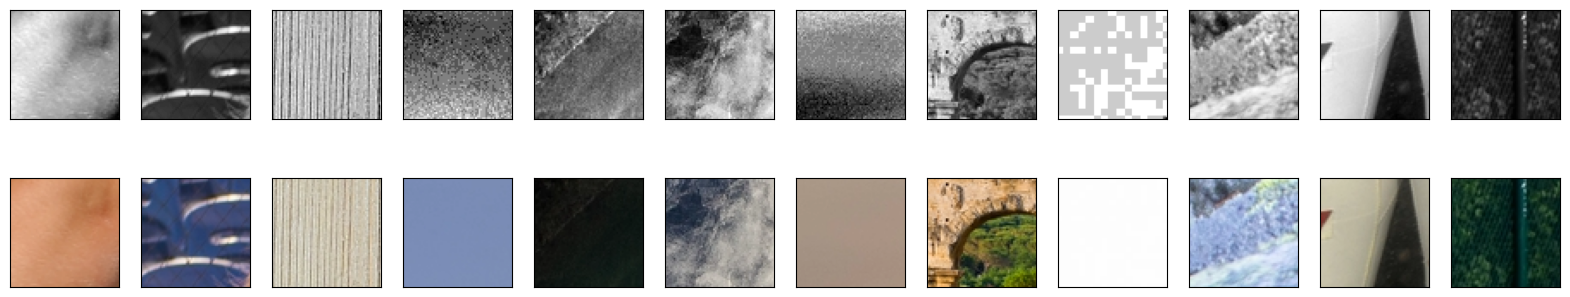

In [ ]:
# Display the train data and a noisy version of it
display2(y_train, uv_train, patchsize)

**Build and Train the CNN**

We are going to use the Functional API to build our convolutional neural network.

In [ ]:
def generate_cnn(input_size=None):

  my_learning_rate = 0.001

  input = layers.Input(shape=(input_size, input_size, 1))

  x = layers.Conv2D(32, (5, 5), activation="relu", strides=(2, 2), padding="same")(input)
  x = layers.Conv2D(24, (5, 5), activation="relu", padding="same")(x)
  x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
  x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
  output = layers.Conv2D(2, (3, 3), activation=None, padding="same")(x)

  # CNN
  cnn = Model(input, output)
  cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="mean_squared_error", metrics=['mse'])

  return cnn


my_cnn = generate_cnn()
my_cnn.summary()

# To get FLOPS need to use a model with any non-None input shape
# Then to get flops per pixel divide by number of pixels
my_cnn2 = generate_cnn(patchsize)
(_, _) = net_flops(my_cnn2, patchsize * patchsize, table=True)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_20 (Conv2D)          (None, None, None, 32)    832       
                                                                 
 conv2d_21 (Conv2D)          (None, None, None, 24)    19224     
                                                                 
 conv2d_22 (Conv2D)          (None, None, None, 16)    3472      
                                                                 
 conv2d_23 (Conv2D)          (None, None, None, 8)     1160      
                                                                 
 conv2d_24 (Conv2D)          (None, None, None, 2)     146       
                                                                 
Total params: 24834 (97.01 KB)
Trainable params: 24834 (97.

Now that we have our network, let's train it using the noisy data as our input and the clean data as our target. We want our CNN to learn how to super-resolve images in the presencce of compression noise.

In [ ]:
# Mount your Google drive to write the model generated
from google.colab import drive
model_out  = '/content/drive/MyDrive/Colab Notebooks/colorizeA.keras'

# Train network
my_cnn.fit(
    x=y_train_norm,
    y=uv_train_norm,
    epochs=25,
    batch_size=1024,
    shuffle=True,
    validation_data=(y_valid_norm, uv_valid_norm),
)

# Save trained network
my_cnn.save(model_out)

Epoch 1/25
453/453 [==============================] - 58s 110ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 2/25
453/453 [==============================] - 57s 126ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 3/25
453/453 [==============================] - 57s 126ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 4/25
453/453 [==============================] - 57s 126ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 5/25
453/453 [==============================] - 57s 126ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 6/25
453/453 [==============================] - 57s 126ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/25
453/453 [==============================] - 57s 126ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 8/25
453/453 [==============================] - 5

Let's now predict on the noisy validation data and display the results from our trained network.

Notice how the CNN reduces the MSE between the source and the noisy images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

my_cnn = tf.keras.models.load_model(model_out)

restored_valid_data = round_postpredict(my_cnn.predict(noisy_valid_data))
display3(valid_data, noisy_valid_data, restored_valid_data, patchsize)

loss_restored_valid = get_mse(valid_data, restored_valid_data)
print('Validation Restored MSE: ' + str(loss_restored_valid))
valid_loss_pct = (loss_noisy_valid - loss_restored_valid) / loss_noisy_valid * 100
print('Validation MSE Reduction %: ' + str(valid_loss_pct))

Mounted at /content/drive


NameError: ignored

Test your pre-trained network on test data.

In [ ]:
# Load the trained model and test the reduction in MSE achieved
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load the test data
test_data, noisy_test_data, testpatchsize = load_url(test_url)

my_cnn = tf.keras.models.load_model(model_out)

# Normalize and reshape the data
test_data = preprocess(test_data, testpatchsize)
noisy_test_data = preprocess(noisy_test_data, testpatchsize)
loss_noisy_test = get_mse(test_data, noisy_test_data)
print('Test Noisy MSE: ' + str(loss_noisy_test))

restored_test_data = round_postpredict(my_cnn.predict(noisy_test_data))
loss_restored_test = get_mse(test_data, restored_test_data)
print('Test Restored MSE: ' + str(loss_restored_test))

test_loss_pct = (loss_noisy_test - loss_restored_test) / loss_noisy_test * 100
print('Test MSE Reduction %: ' + str(test_loss_pct))

display3(test_data, noisy_test_data, restored_test_data, testpatchsize)